In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import logging
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sep
import pandas as pd
import os
from astropy.table import Table, vstack

import matplotlib.image as mpimg
import matplotlib as mpl

mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command

/tmp/ipykernel_7441/2724227703.py:15: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command


In [3]:
from maddeb.utils import listdir_fullpath, get_data_dir_path
import maddeb.boxplot

In [4]:
logging.basicConfig(format="%(message)s", level=logging.INFO)
LOG = logging.getLogger(__name__)

## load the saved results

In [5]:
density_level = "high"

In [6]:
data_path = "/sps/lsst/users/bbiswas/MADNESS_results/" + density_level + "_density"
run_name = "kl1" # 12 to 20 galaxies
result_dir_path = os.path.join(data_path, run_name)

In [7]:
scarlet_plot_color = sns.color_palette("colorblind")[4]
madness_plot_color = sns.color_palette("colorblind")[0]
debvader_plot_color = sns.color_palette("colorblind")[2]

blended_plot_color = sns.color_palette("colorblind")[1]
isolated_plot_color = sns.color_palette("colorblind")[6]


scarlet_plot_ls = "-"
madness_plot_ls = "dashdot"
debvader_plot_ls = "dotted"
blended_plot_ls = "--"

scarlet_plot_label = r'\texttt{scarlet}'
madness_plot_label = r'\texttt{MADNESS}'
debvader_plot_label = r'\texttt{VAE-deblender}'

In [8]:
madness_results=[]
debvader_results=[]
scarlet_results=[]
actual_photometry = []
blended_photometry = []

for file_num in range(300):

    madness_results.append(pd.read_pickle(os.path.join(result_dir_path, "madness_results", str(file_num) + ".pkl")))
    debvader_results.append(pd.read_pickle(os.path.join(result_dir_path, "debvader_results", str(file_num) + ".pkl")))
    scarlet_results.append(pd.read_pickle(os.path.join(data_path, "scarlet_results", str(file_num) + ".pkl")))

    actual_photometry.append(pd.read_pickle(os.path.join(data_path, "actual_photometry", str(file_num) + ".pkl")))
    blended_photometry.append(pd.read_pickle(os.path.join(data_path, "blended_photometry",  str(file_num) + ".pkl")))

madness_results = pd.concat(madness_results)
debvader_results = pd.concat(debvader_results)
scarlet_results = pd.concat(scarlet_results)

actual_photometry = pd.concat(actual_photometry)
blended_photometry = pd.concat(blended_photometry)

In [9]:
# mask_contamination=madness_results["r_contamination"].values<5
# madness_results=madness_results[mask_contamination]
# scarlet_results=scarlet_results[mask_contamination]
# actual_photometry=actual_photometry[mask_contamination]
# blended_photometry=blended_photometry[mask_contamination]

In [10]:
madness_results.columns

Index(['u_cosd', 'u_ssim', 'u_blendedness', 'g_cosd', 'g_ssim',
       'g_blendedness', 'r_cosd', 'r_ssim', 'r_blendedness', 'i_cosd',
       'i_ssim', 'i_blendedness', 'z_cosd', 'z_ssim', 'z_blendedness',
       'y_cosd', 'y_ssim', 'y_blendedness', 'galaxy_num', 'size', 'field_num',
       'file_num', 'r_band_snr', 'ref_mag', 'u_ab', 'g_ab', 'r_ab', 'i_ab',
       'z_ab', 'y_ab', 'u_phot_flux', 'u_phot_fluxerrs', 'u_phot_flags',
       'g_phot_flux', 'g_phot_fluxerrs', 'g_phot_flags', 'r_phot_flux',
       'r_phot_fluxerrs', 'r_phot_flags', 'i_phot_flux', 'i_phot_fluxerrs',
       'i_phot_flags', 'z_phot_flux', 'z_phot_fluxerrs', 'z_phot_flags',
       'y_phot_flux', 'y_phot_fluxerrs', 'y_phot_flags', 'r_contamination'],
      dtype='object')

In [11]:
from scipy.optimize import curve_fit

In [12]:
def gauss(x, sig, mu):
    return 1/np.sqrt(2.*np.pi)/sig*np.exp(-0.5*(x-mu)**2/sig**2)

# hist, bin_tmp = np.histogram(flux_est/flux_true-1, n_bins, density=True)
# bins = np.mean((bin_tmp[:-1], bin_tmp[1:]), 0)
# res = curve_fit(gauss, bins, hist, p0=[np.std(bins), np.mean(bins)])

1.1080300066181619


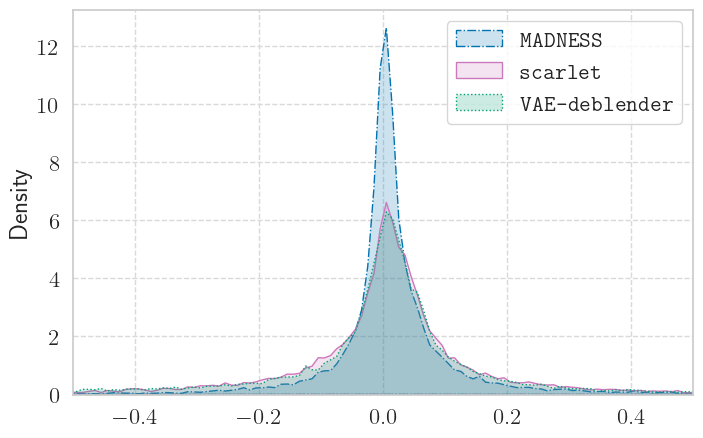

In [13]:
band='r'
mask = madness_results['r_contamination']>.05
bins = np.arange(-10, 10, .01)


plt.figure(figsize=(8, 5))
sns.set(font_scale=1.5)
sns.set_style("whitegrid", {"grid.color": ".85", 'grid.linestyle': '--'})
madness_rel_aper_phot_err = (madness_results[band+"_phot_flux"].values[mask] / actual_photometry[band+"_phot_flux"].values[mask] - 1)
sns.histplot((madness_results[band+"_phot_flux"].values[mask] / actual_photometry[band+"_phot_flux"].values[mask] - 1), 
    bins=bins,
    label=madness_plot_label,
    color=madness_plot_color,
    alpha=.2,
    element="poly",
    stat='density',
    ls=madness_plot_ls,
)
# print(np.sqrt(np.sum((madness_rel_aper_phot_err - np.mean(madness_rel_aper_phot_err))**2)/len(madness_rel_aper_phot_err)))
# hist, bin_tmp = np.histogram((madness_results[band+"_phot_flux"].values[mask] / actual_photometry[band+"_phot_flux"].values[mask] - 1), bins, density=True)
# bins = np.mean((bin_tmp[:-1], bin_tmp[1:]), 0)
# res = curve_fit(gauss, bins, hist, p0=[.001, 0])
# print(res[0])
# plt.plot(bins, gauss(bins, res[0][0], res[0][1]))

scarlet_rel_aper_phot_err = (scarlet_results[band+"_phot_flux"].values[mask] / actual_photometry[band+"_phot_flux"].values[mask] - 1)
sns.histplot((scarlet_results[band+"_phot_flux"].values[mask] - actual_photometry[band+"_phot_flux"].values[mask]) / actual_photometry[band+"_phot_flux"].values[mask], 
    bins=bins,
    label=scarlet_plot_label,
    color=scarlet_plot_color,
    alpha=.2, 
    element="poly",
    stat='density',
    ls=scarlet_plot_ls,
)
print(np.sqrt(np.sum((scarlet_rel_aper_phot_err - np.mean(scarlet_rel_aper_phot_err))**2)/len(scarlet_rel_aper_phot_err)))
sns.histplot((debvader_results[band+"_phot_flux"].values[mask] - actual_photometry[band+"_phot_flux"].values[mask]) / actual_photometry[band+"_phot_flux"].values[mask], 
    bins=bins,
    label=debvader_plot_label,
    color=debvader_plot_color,
    alpha=.2, 
    element="poly",
    stat='density',
    ls = debvader_plot_ls,
)
plt.xlim(-.5, .5)
plt.legend()

# Pixel Cosine Distance

In [14]:
bins = np.arange(0.95, 1, 0.0002)
for band_number, band in enumerate(['u', 'g', 'r', 'i', 'z', 'y']):
    plt.figure(figsize=(8, 4))
    sns.set_style("whitegrid", {"grid.color": ".85", 'grid.linestyle': '--'})
    mask = (actual_photometry[band+"_phot_flux"].values/actual_photometry[band+"_phot_fluxerrs"].values)>5
    sns.histplot(
        madness_results[mask][band + '_cosd'].values, bins=bins, 
        alpha=0.1, 
        label=madness_plot_label, 
        color=madness_plot_color, 
        element="poly", 
        stat='percent', 
        ls=madness_plot_ls,
        lw=2,
    )
    sns.histplot(
        debvader_results[mask][band + '_cosd'].values, 
        bins=bins, 
        alpha=0.1, 
        label=debvader_plot_label, 
        color=debvader_plot_color, 
        element="poly", 
        stat='percent', 
        ls=debvader_plot_ls, 
        lw=2,
    )
    sns.histplot(
        scarlet_results[mask][band + '_cosd'].values, 
        bins=bins, 
        alpha=0.1, 
        label=scarlet_plot_label, 
        color=scarlet_plot_color, 
        element="poly", 
        stat='percent', 
        ls=scarlet_plot_ls,
        lw=2,
    )
    plt.legend()
    plt.xlim([0.975, 1])
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.xlabel("pixel cosine distance", fontsize=25)
    plt.ylabel("$\%$ of galaxies", fontsize=25)
    plt.legend(fontsize=20, title=band+"-filter", loc="upper left", title_fontsize=20)
    ax = plt.gca()
    plt.tight_layout()
    #plt.savefig(result_dir_path + "/cosd_res_"+band)
    plt.savefig(os.path.join("results", density_level + "_density", "cosd_res_"+band), bbox_inches="tight")
    plt.savefig(os.path.join("results", density_level + "_density", "cosd_res_"+band+".pdf"), format="pdf", bbox_inches="tight")
    plt.close()

In [15]:
shift_rng = np.random.default_rng(12345)

In [16]:
shift_rng = np.random.default_rng(12345)
for i in range(20):
    print(shift_rng.random())

0.22733602246716966
0.31675833970975287
0.7973654573327341
0.6762546707509746
0.391109550601909
0.33281392786638453
0.5983087535871898
0.18673418560371335
0.6727560440146213
0.9418028652699372
0.248245714629571
0.9488811518333182
0.6672374531003724
0.09589793559411208
0.4418396661678128
0.8864799193275177
0.6974534998820221
0.3264728640701121
0.7339281633300665
0.22013495554548623


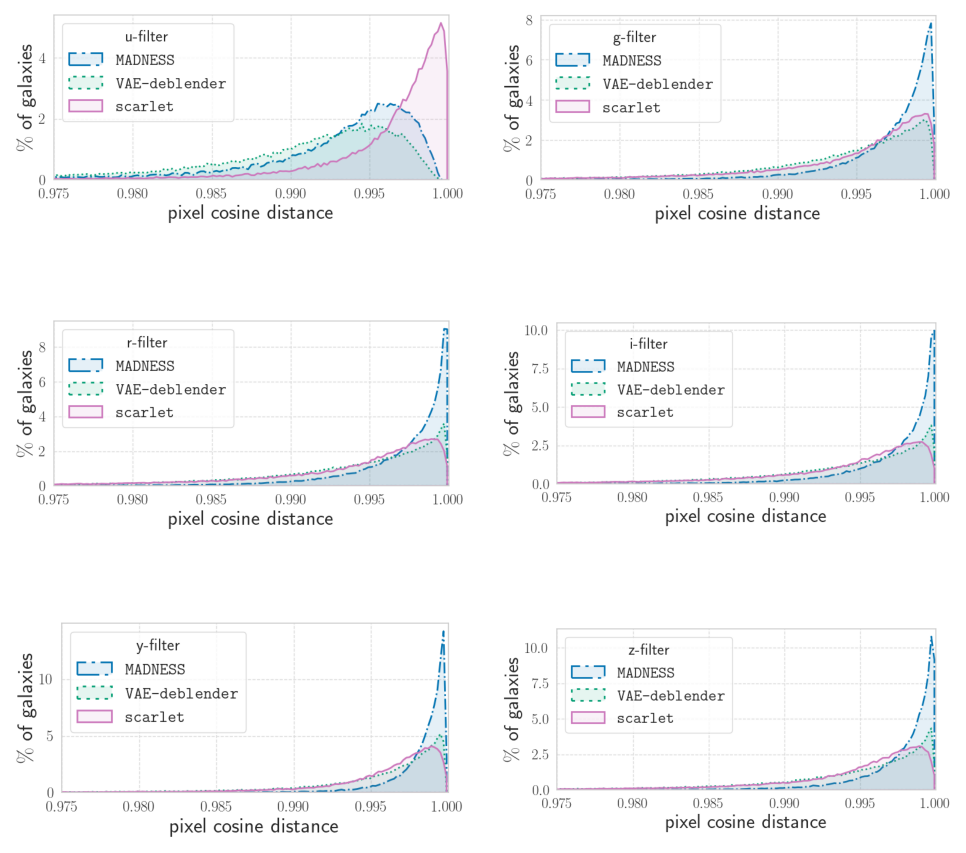

In [17]:
f, axarr = plt.subplots(3, 2, figsize=(10, 10))

for band_num, band in enumerate(['u', 'g', 'r', 'i', 'y', 'z']):
#axarr[0].imshow(mpimg.imread(os.path.join(result_dir_path, "cumulative_distib_phot_err_r.png")))
    axarr[int(band_num/2)][band_num%2].imshow(mpimg.imread(os.path.join("results", density_level + "_density", f"cosd_res_{band}.png")))

# turn off x and y axis
[ax.set_axis_off() for ax in axarr.ravel()]
plt.tight_layout()

plt.savefig(os.path.join("results", density_level + "_density", "cosd_res.pdf"), format="pdf", bbox_inches="tight", dpi=1200)
plt.savefig(os.path.join("results", density_level + "_density", "cosd_res.png"))

plt.show()

# Relative error in apperture photometry (elliptical apertures)

In [18]:
for band in ['u', 'g', 'r', 'i', 'z', 'y']:

    #sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
    sns.set_style("whitegrid", {"grid.color": ".85", 'grid.linestyle': '--'})
#     sns.set_theme(style={"axes.grid": True,'grid.color': 'black',
# })
    plt.figure(figsize=(8, 5))
    bins = np.arange(-1, 1, 0.0001)
    mask = (actual_photometry[band+"_phot_flux"].values/actual_photometry[band+"_phot_fluxerrs"].values)>5
    x = sns.histplot(
        np.abs((madness_results[band+"_phot_flux"].values[mask] - actual_photometry[band+"_phot_flux"].values[mask]) / actual_photometry[band+"_phot_flux"].values[mask]),
        bins=bins,
        stat='density',
        alpha=0,
        cumulative=True,
        color=madness_plot_color,
        element="step",
        ls=madness_plot_ls,
        linewidth=2,
    )
    plt.plot([], [], ls=madness_plot_ls, lw=2, color=madness_plot_color, label=madness_plot_label)

    sns.histplot(
        np.abs((debvader_results[band+"_phot_flux"].values[mask] - actual_photometry[band+"_phot_flux"].values[mask]) / actual_photometry[band+"_phot_flux"].values[mask]),
        bins=bins,
        stat='density',
        alpha=0,
        cumulative=True,
        color=debvader_plot_color,
        element="step",
        ls=debvader_plot_ls,
        linewidth=2,
    )
    plt.plot([], [], ls=debvader_plot_ls, lw=2, color=debvader_plot_color, label=debvader_plot_label)
    
    sns.histplot(
        np.abs((scarlet_results[band+"_phot_flux"].values[mask] - actual_photometry[band+"_phot_flux"].values[mask]) / actual_photometry[band+"_phot_flux"].values[mask]),
        bins=bins,
        stat='density',
        alpha=0,
        cumulative=True,
        color=scarlet_plot_color,
        element="step",
        linewidth=2,
        ls=scarlet_plot_ls,
    )
    plt.plot([], [], ls=scarlet_plot_ls, lw=2, color=scarlet_plot_color, label=scarlet_plot_label)

    sns.histplot(
        np.abs((blended_photometry[band+"_phot_flux"].values[mask] - actual_photometry[band+"_phot_flux"].values[mask]) / actual_photometry[band+"_phot_flux"].values[mask]),
        bins=bins,
        stat='density',
        alpha=0,
        cumulative=True,
        color=blended_plot_color,
        ls=blended_plot_ls,
        linewidth=2,
        element="step",
    )
    plt.plot([], [], ls=blended_plot_ls, lw=2, color=blended_plot_color, label="blended")

    ax = plt.gca()
    #ax.grid(color='lightgray', linestyle='-', linewidth=2)
    plt.xlim([0, .1])
    plt.ylim([.25, 1])
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel("| relative photometry error |", fontsize=20)
    plt.ylabel("cumulative fraction", fontsize=20)
    plt.legend(fontsize=20, title=f"{band}-filter", loc="lower right", title_fontsize=20)
    plt.tight_layout()
    plt.savefig("results/"+ density_level + "_density/cumulative_distib_phot_err_"+band)
    plt.savefig("results/"+ density_level + "_density/cumulative_distib_phot_err_"+band + ".pdf", format="pdf", bbox_inches="tight")
    plt.close()

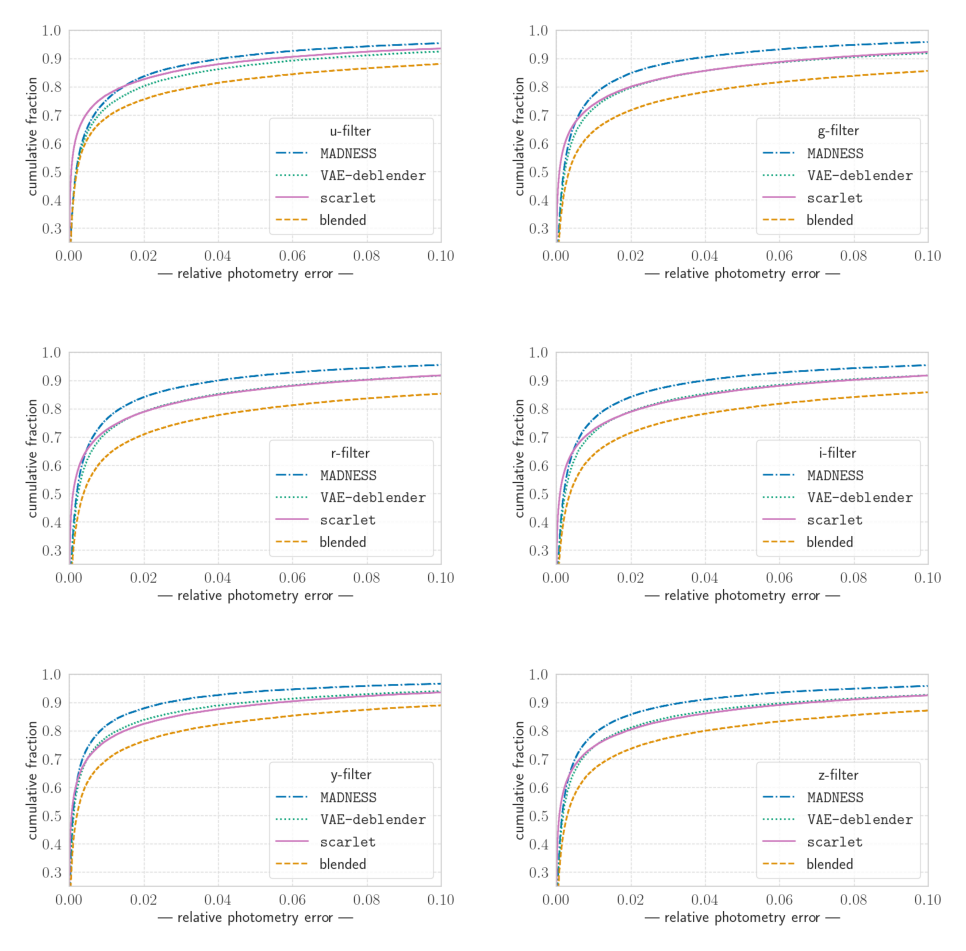

In [19]:
f, axarr = plt.subplots(3, 2, figsize=(10, 10))

for band_num, band in enumerate(['u', 'g', 'r', 'i', 'y', 'z']):
#axarr[0].imshow(mpimg.imread(os.path.join(result_dir_path, "cumulative_distib_phot_err_r.png")))
    axarr[int(band_num/2)][band_num%2].imshow(mpimg.imread(os.path.join("results", f"{density_level}_density/cumulative_distib_phot_err_{band}.png")))

# turn off x and y axis
[ax.set_axis_off() for ax in axarr.ravel()]
plt.tight_layout()

plt.savefig(os.path.join("results", density_level + "_density", "cumulative_distib_phot_err.pdf"), format="pdf", bbox_inches="tight", dpi=1200)
plt.savefig(os.path.join("results", density_level + "_density", "cumulative_distib_phot_err.png"))

plt.show()

# Box plots

SNR definition here is one used to place the SNR>10 cut on the catalog.

In [20]:
boxplot_snr_df = {}

r_snr_mask = (actual_photometry["r_phot_flux"].values/actual_photometry["r_phot_fluxerrs"].values)>5

# madness_actual_flux = madness_results[band+"_actual_flux"].value
# madness_predicted_flux = madness_results[band+"_predicted_flux"].value

# scarlet_actual_flux = scarlet_results[band+"_actual_flux"].value
# scarlet_predicted_flux = scarlet_results[band+"_predicted_flux"].value

# scarlet_relative_difference = np.divide(
#     scarlet_predicted_flux - scarlet_actual_flux, scarlet_actual_flux
# )
# madness_relative_difference = np.divide(
#     madness_predicted_flux - madness_actual_flux, madness_actual_flux
# )
boxplot_snr_df["snr"] = list(madness_results['r_band_snr'][r_snr_mask])
boxplot_snr_df["type"] = ["madness"] * len(madness_results[r_snr_mask])
#boxplot_snr_df["r_relative_flux_err"] = list(madness_relative_difference)
boxplot_snr_df["r_relative_flux_err"] = list(np.abs(madness_results["r_phot_flux"].values[r_snr_mask] - actual_photometry["r_phot_flux"].values[r_snr_mask]) / actual_photometry["r_phot_flux"].values[r_snr_mask])


boxplot_snr_df["snr"].extend(list(scarlet_results['r_band_snr'][r_snr_mask]))
boxplot_snr_df["type"].extend(["scarlet"] * len(scarlet_results[r_snr_mask]))
boxplot_snr_df["r_relative_flux_err"].extend(list(np.abs(scarlet_results["r_phot_flux"].values[r_snr_mask] - actual_photometry["r_phot_flux"].values[r_snr_mask]) / actual_photometry["r_phot_flux"].values[r_snr_mask])) 

boxplot_snr_df = pd.DataFrame(boxplot_snr_df)

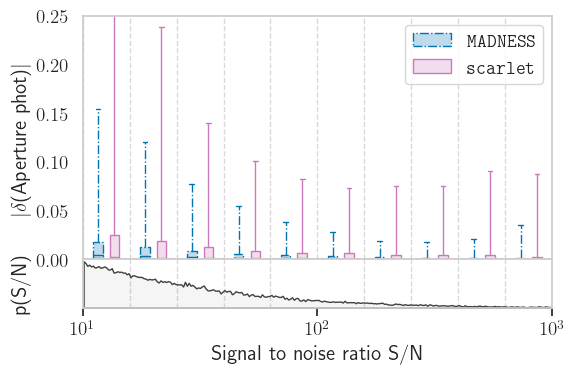

In [21]:
fig, median_fluxerr, q1_fluxerr, q3_fluxerr, whislo_fluxerr, whishi_fluxerr = maddeb.boxplot.boxplot_func(
    boxplot_snr_df, 
    x = 'snr', y = "r_relative_flux_err", z = "type",
    xlim = (10, 1000),
    ylim = (0, 0.25), 
    x_scale = 'log',
    legend = [madness_plot_label, scarlet_plot_label],
    x_label='Signal to noise ratio S/N', 
    y_label = r'$|\delta$(Aperture phot)$|$',
    y_label_hist='p(S/N)',
    legend_remove = False,
    legend_location = "upper right",
#     x_ticks=[10, 20, 30, 40, 60, 100],
#     x_ticklabels=[r'$10$', r'$20$', r'$30$', r'$40$', r'$60$', r'$100$'],
    whis = [5,95],
    percents = [25,75],
    palette = [madness_plot_color, scarlet_plot_color],#0.35,
    ls = [madness_plot_ls, scarlet_plot_ls],
    nbins = 10,
)

plt.savefig(os.path.join("results", density_level + "_density", "snr_box_plot.pdf"))
plt.savefig(os.path.join("results", density_level + "_density", "snr_box_plot.png"))

In [22]:
madness_results

,u_cosd,u_ssim,u_blendedness,g_cosd,g_ssim,g_blendedness,r_cosd,r_ssim,r_blendedness,i_cosd,...,i_phot_flux,i_phot_fluxerrs,i_phot_flags,z_phot_flux,z_phot_fluxerrs,z_phot_flags,y_phot_flux,y_phot_fluxerrs,y_phot_flags,r_contamination
0,0.982797,0.999073,0.131162,0.992096,0.999761,0.469463,0.992241,0.999785,0.655093,0.989862,...,22380.534961,3412.864287,0,33361.546319,3902.107847,0,16693.840379,4187.370411,0,1.911186
1,0.983440,0.999108,0.008478,0.999479,0.999960,0.007969,0.999853,0.999987,0.011934,0.999828,...,142650.717254,3224.489218,0,121260.347255,3667.382735,0,66838.969274,3942.447703,0,0.011798
2,0.271877,0.993912,0.049146,0.973194,0.998851,0.030588,0.997816,0.999890,0.008035,0.997710,...,42571.408660,3432.091843,0,51971.819625,3926.199075,0,31263.977468,4220.803040,0,0.007196
3,0.148878,0.994353,0.867055,0.992724,0.999660,0.525110,0.997502,0.999918,0.338726,0.997052,...,77544.458051,3245.959683,0,72440.286430,3690.316748,0,37394.402092,3974.993790,0,0.545165
4,0.991494,0.999535,0.002891,0.996202,0.999671,0.002766,0.995517,0.999649,0.004563,0.994954,...,27882.272252,3452.271422,0,22245.872272,3933.776179,0,12399.981383,4238.802282,0,0.004191
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
322,0.969934,0.998442,0.001313,0.996274,0.999812,0.001797,0.998198,0.999864,0.001156,0.997629,...,39069.600893,3416.239746,0,48538.895310,3896.849843,0,37810.853090,4158.436400,0,0.000549
323,0.993800,0.999298,0.000992,0.996417,0.999687,0.001400,0.996437,0.999718,0.002615,0.997032,...,15766.236891,3753.979622,0,11355.264152,4308.768662,0,8098.229498,4618.465489,0,0.001450
324,0.993611,0.999316,0.000265,0.998861,0.999821,0.000547,0.999024,0.999862,0.001049,0.999287,...,105518.948337,4178.788807,0,80807.926799,4801.635003,0,37901.785129,5145.417179,0,0.000625
325,0.656074,0.994910,0.002836,0.998134,0.999881,0.000468,0.999843,0.999988,0.000123,0.999904,...,421509.586069,3517.234089,0,368955.557449,4024.485017,0,208146.561139,4310.990020,0,0.000068


In [23]:
np.sum(mask)

52325

In [24]:
boxplot_blendedness_df = {}

boxplot_blendedness_df['r_blendedness'] = list(madness_results['r_blendedness'][r_snr_mask])
boxplot_blendedness_df['r_contamination'] = list(madness_results['r_contamination'][r_snr_mask])
boxplot_blendedness_df["type"] = ["madness"] * len(madness_results[r_snr_mask])
boxplot_blendedness_df["r_relative_flux_err"] = list(np.abs(madness_results["r_phot_flux"].values[r_snr_mask] - actual_photometry["r_phot_flux"].values[r_snr_mask]) / actual_photometry["r_phot_flux"].values[r_snr_mask])


boxplot_blendedness_df['r_blendedness'].extend(list(scarlet_results['r_blendedness'][r_snr_mask]))
boxplot_blendedness_df['r_contamination'].extend(list(madness_results['r_contamination'][r_snr_mask]))
boxplot_blendedness_df["type"].extend(["scarlet"] * len(scarlet_results[r_snr_mask]))
boxplot_blendedness_df["r_relative_flux_err"].extend(list(np.abs(scarlet_results["r_phot_flux"].values[r_snr_mask] - actual_photometry["r_phot_flux"].values[r_snr_mask]) / actual_photometry["r_phot_flux"].values[r_snr_mask])) 

boxplot_blendedness_df = pd.DataFrame(boxplot_blendedness_df)

In [25]:
np.amin(boxplot_blendedness_df['r_blendedness'])

1.433849799670206e-06

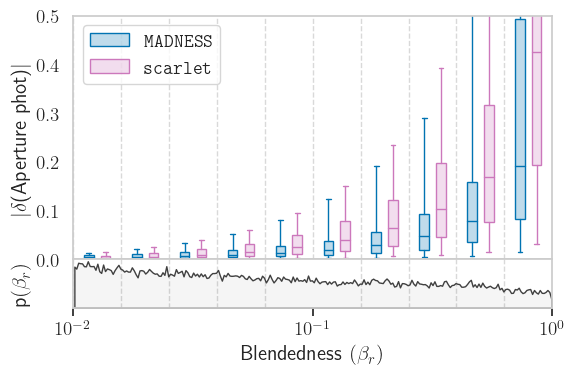

In [26]:
fig, median_shear, q1_shear, q3_shear, whislo_shear, whishi_shear = maddeb.boxplot.boxplot_func(
    boxplot_blendedness_df, 
    x = 'r_blendedness', y = "r_relative_flux_err", z = "type",
    xlim = (1e-2, 1),
    ylim = (-0, .5), 
    x_scale = 'log',
    legend = [madness_plot_label, scarlet_plot_label],
    x_label=r'Blendedness $(\beta_r)$', 
    y_label = r'$|\delta$(Aperture phot)$|$',
    y_label_hist=r'p$(\beta_r)$',
    legend_remove = False,
    whis = [5, 95],
    percents = [25, 75],
    palette=[madness_plot_color, scarlet_plot_color],#0.35,
    nbins = 10,
)
plt.savefig(os.path.join("results", density_level + "_density", "blendedness_box_plot.pdf"))
plt.savefig(os.path.join("results", density_level + "_density",  "blendedness_box_plot.png"))

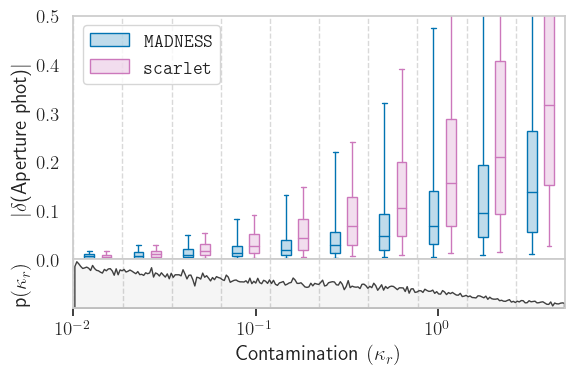

In [27]:
fig, median_shear, q1_shear, q3_shear, whislo_shear, whishi_shear = maddeb.boxplot.boxplot_func(
    boxplot_blendedness_df, 
    x = 'r_contamination', y = "r_relative_flux_err", z = "type",
    xlim = (1e-2, 5),
    ylim = (0, .5), 
    x_scale = 'log',
    legend = [madness_plot_label, scarlet_plot_label],
    x_label=r'Contamination $(\kappa_r)$', 
    y_label = r'$|\delta$(Aperture phot)$|$',
    y_label_hist=r'p$(\kappa_r)$',
    legend_remove = False,
    whis = [5, 95],
    percents = [25, 75],
    palette=[madness_plot_color, scarlet_plot_color],#0.35,
    nbins = 10,
)
plt.savefig(os.path.join("results", density_level + "_density", "contamination_box_plot.pdf"))
plt.savefig(os.path.join("results", density_level + "_density",  "contamination_box_plot.png"))

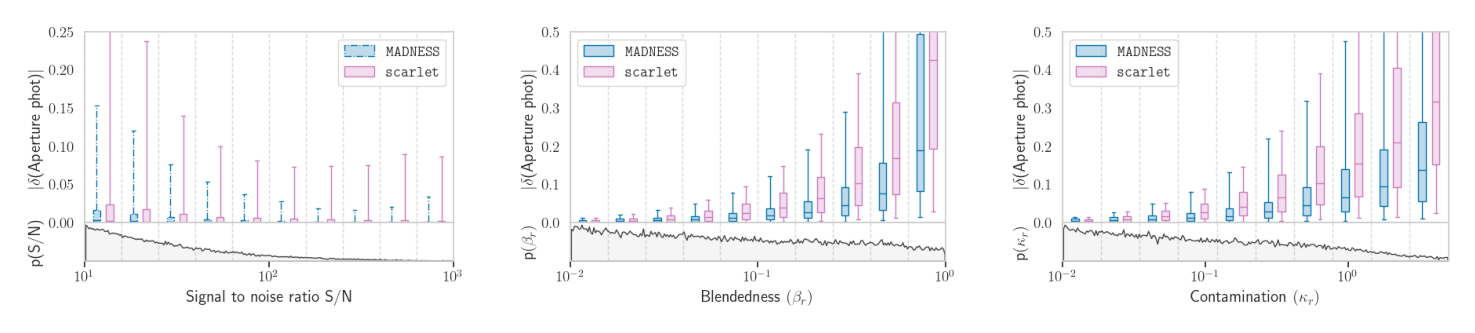

In [28]:
f, axarr = plt.subplots(1, 3, figsize=(15, 5))


#axarr[0].imshow(mpimg.imread(os.path.join(result_dir_path, "cumulative_distib_phot_err_r.png")))
axarr[0].imshow(mpimg.imread(os.path.join("results", density_level + "_density", "snr_box_plot.png")))
axarr[1].imshow(mpimg.imread(os.path.join("results", density_level + "_density", "blendedness_box_plot.png")))
axarr[2].imshow(mpimg.imread(os.path.join("results", density_level + "_density", "contamination_box_plot.png")))

# turn off x and y axis
[ax.set_axis_off() for ax in axarr.ravel()]
plt.tight_layout()

plt.savefig("results/" + density_level + "_density/boxplot_results.pdf", format="pdf", bbox_inches="tight")
plt.savefig("results/" + density_level + "_density/boxplot_results.png")

plt.show()